In [3]:
# !pwd
%cd /home/jovyan/AI_Master/Flex_NLP/

/home/jovyan/AI_Master/Flex_NLP


In [17]:
from config import *

import numpy as np 
import pandas as pd 
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from transformers import AdamW
from functools import partial



# transformers
import fastai
import transformers
from flex_transformer import *  
from transformers import AdamW

from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig

from dataMgr import *

"""# Model Configuration
# model_class.pretrained_model_archive_map.keys()

[bert]
dict_keys(['bert-base-uncased', 'bert-large-uncased', 'bert-base-cased', 
'bert-large-cased', 'bert-base-multilingual-uncased', 'bert-base-multilingual-cased', 
'bert-base-chinese', 'bert-base-german-cased', 'bert-large-uncased-whole-word-masking', 
'bert-large-cased-whole-word-masking', 'bert-large-uncased-whole-word-masking-finetuned-squad', 
'bert-large-cased-whole-word-masking-finetuned-squad', 'bert-base-cased-finetuned-mrpc', 
'bert-base-german-dbmdz-cased', 'bert-base-german-dbmdz-uncased', 'bert-base-japanese', 
'bert-base-japanese-whole-word-masking', 'bert-base-japanese-char', 'bert-base-japanese-char-whole-word-masking', 
'bert-base-finnish-cased-v1', 'bert-base-finnish-uncased-v1', 'bert-base-dutch-cased'])

[xlnet]
dict_keys(['xlnet-base-cased', 'xlnet-large-cased'])

[xlm]
dict_keys(['xlm-mlm-en-2048', 'xlm-mlm-ende-1024', 'xlm-mlm-enfr-1024', 'xlm-mlm-enro-1024', 
'xlm-mlm-tlm-xnli15-1024', 'xlm-mlm-xnli15-1024', 'xlm-clm-enfr-1024', 'xlm-clm-ende-1024', 
'xlm-mlm-17-1280', 'xlm-mlm-100-1280'])

[roberta]
dict_keys(['roberta-base', 'roberta-large', 'roberta-large-mnli', 'distilroberta-base', 
'roberta-base-openai-detector', 'roberta-large-openai-detector'])

[distilbert]
dict_keys(['distilbert-base-uncased', 'distilbert-base-uncased-distilled-squad', 'distilbert-base-cased', 
'distilbert-base-cased-distilled-squad', 'distilbert-base-german-cased', 'distilbert-base-multilingual-cased', 
'distilbert-base-uncased-finetuned-sst-2-english'])
"""
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig), # bert-base-uncased
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig), # xlnet-base-cased'
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig), # xlm-mlm-en-2048
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig), # distilroberta-base
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig) # distilbert-base-uncased
}



def load_pretrained_model(model_type, pretrained_model_name):
    model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]
    config = config_class.from_pretrained(pretrained_model_name)
    # config.num_labels = n_label
    config.num_labels = 5

    transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
    # transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)
    custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

    return custom_transformer_model


def fine_tuned_model(custom_transformer_model, databunch, model_path):

    CustomAdamW = partial(AdamW, correct_bias=False)
    
    learner = Learner(databunch, 
                custom_transformer_model, 
                opt_func = CustomAdamW, 
                metrics=[accuracy, error_rate])

        
    # For DistilBERT
    list_layers = [learner.model.transformer.distilbert.embeddings,
                learner.model.transformer.distilbert.transformer.layer[0],
                learner.model.transformer.distilbert.transformer.layer[1],
                learner.model.transformer.distilbert.transformer.layer[2],
                learner.model.transformer.distilbert.transformer.layer[3],
                learner.model.transformer.distilbert.transformer.layer[4],
                learner.model.transformer.distilbert.transformer.layer[5],
                learner.model.transformer.pre_classifier]

    learner.split(list_layers)
    num_groups = len(learner.layer_groups)
    print('Learner split in',num_groups,'groups')
    print(learner.layer_groups)


    ## Train
    learner.save('untrain')

    seed_all(seed_val)
    learner.load('untrain')

    learner.freeze_to(-1)
    learner.summary()

    learner.lr_find()
    # learner.recorder.plot(skip_end=10,suggestion=True)

    learner.fit_one_cycle(1,max_lr=2e-03,moms=(0.8,0.7))
    learner.save('first_cycle')

    seed_all(seed_val)
    learner.load('first_cycle')

    learner.freeze_to(-2)
    lr = 1e-5

    learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
    learner.save('second_cycle')

    seed_all(seed_val)
    learner.load('second_cycle')

    learner.freeze_to(-3)
    learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

    learner.save('third_cycle')

    learner.export(file = model_path)

    return learner




def get_model_info():
    print("====================================== Model ======================================")
    print("분석하고자 하는 모델 정보를 입력해주세요.")
    # print("pre_trained 모델을 선택해주세요. \n 1:distilbert 2:bert 3:roberta 4:.... (TBD)")
    model_i = 1
    # print("분석 NLP Task를 선택해주세요. \n 1: multi-label classification 2:ner 3:squad 4:..... (TBD)")
    task_i = 1
    # print("Class Label 개수를 입력해주세요.")
    # n_label = int(input())
    n_label = 5

    model_info = [model_dict[model_i], task_dict[task_i], n_label]

    print("=================== 입력해주신 Model 정보입니다 ===================")
    print("[분석 모델, NLP Task, Label 개수]")
    print(model_info)

    return model_dict[model_i], task_dict[task_i], n_label

def get_list_layers(learner, model_type):
    if(model_type == "distilbert"):
        # For DistilBERT
        list_layers = [learner.model.transformer.distilbert.embeddings,
                    learner.model.transformer.distilbert.transformer.layer[0],
                    learner.model.transformer.distilbert.transformer.layer[1],
                    learner.model.transformer.distilbert.transformer.layer[2],
                    learner.model.transformer.distilbert.transformer.layer[3],
                    learner.model.transformer.distilbert.transformer.layer[4],
                    learner.model.transformer.distilbert.transformer.layer[5],
                    learner.model.transformer.pre_classifier]
    elif(model_type == "bert"):
        # # For BERT
        list_layers = [learner.model.transformer.bert.embeddings,
                    learner.model.transformer.bert.encoder.layer[0],
                    learner.model.transformer.bert.encoder.layer[1],
                    learner.model.transformer.bert.encoder.layer[2],
                    learner.model.transformer.bert.encoder.layer[3],
                    learner.model.transformer.bert.encoder.layer[4],
                    learner.model.transformer.bert.encoder.layer[5],
                    learner.model.transformer.bert.encoder.layer[6],
                    learner.model.transformer.bert.encoder.layer[7],
                    learner.model.transformer.bert.encoder.layer[8],
                    learner.model.transformer.bert.encoder.layer[9],
                    learner.model.transformer.bert.encoder.layer[10],
                    learner.model.transformer.bert.encoder.layer[11],
                    learner.model.transformer.bert.pooler,
                    learner.model.transformer.dropout,
                    # learner.model.transformer.lin1,
                    # learner.model.transformer.lin2,
                    # learner.model.transformer.lin3,
                    # learner.model.transformer.lin4,
                    learner.model.transformer.classifier]
    # elif(model_type == "xlnet"):
        # # For XLNet
        # list_layers = [learner.model.transformer.xlnet.embeddings,
        #             learner.model.transformer.xlnet.transformer.layer[0],
        #             learner.model.transformer.xlnet.transformer.layer[1],
        #             learner.model.transformer.xlnet.transformer.layer[2],
        #             learner.model.transformer.xlnet.transformer.layer[3],
        #             learner.model.transformer.xlnet.transformer.layer[4],
        #             learner.model.transformer.xlnet.transformer.layer[5],
        #             learner.model.transformer.xlnet.transformer.layer[6],
        #             learner.model.transformer.xlnet.transformer.layer[7],
        #             learner.model.transformer.xlnet.transformer.layer[8],
        #             learner.model.transformer.xlnet.transformer.layer[9],
        #             learner.model.transformer.xlnet.transformer.layer[10],
        #             learner.model.transformer.xlnet.transformer.layer[11],
        #             learner.model.transformer.pre_classifier]
    elif(model_type == "roberta"):
        # For Roberta
        list_layers = [learner.model.transformer.roberta.embeddings,
                learner.model.transformer.roberta.encoder.layer[0],
                learner.model.transformer.roberta.encoder.layer[1],
                learner.model.transformer.roberta.encoder.layer[2],
                learner.model.transformer.roberta.encoder.layer[3],
                learner.model.transformer.roberta.encoder.layer[4],
                learner.model.transformer.roberta.encoder.layer[5],
                learner.model.transformer.roberta.encoder.layer[6],
                learner.model.transformer.roberta.encoder.layer[7],
                learner.model.transformer.roberta.encoder.layer[8],
                learner.model.transformer.roberta.encoder.layer[9],
                learner.model.transformer.roberta.encoder.layer[10],
                learner.model.transformer.roberta.encoder.layer[11],
                learner.model.transformer.roberta.pooler]

    elif(model_type == "distilroberta"): # distilroberta
            # For Roberta
        list_layers = [learner.model.transformer.roberta.embeddings,
                learner.model.transformer.roberta.encoder.layer[0],
                learner.model.transformer.roberta.encoder.layer[1],
                learner.model.transformer.roberta.encoder.layer[2],
                learner.model.transformer.roberta.encoder.layer[3],
                learner.model.transformer.roberta.encoder.layer[4],
                learner.model.transformer.roberta.encoder.layer[5],
                learner.model.transformer.roberta.pooler]

    return list_layers

if __name__ == "__main__":

    data_name = 'movie_en_5label'
    model_type = 'roberta'
    pretrained_model_name = 'roberta-base'

    # data_name = sys.argv[1]
    # model_type = sys.argv[2]
    # pretrained_model_name = sys.argv[3]
    finetuned_model_name = './models/' + data_name + '_' + pretrained_model_name + '.pkl'
        
    train, test, n_label, doc_name, label_name = get_data(data_name)
    model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

    transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
    transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
    fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

    # Custom Processor
    transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
    numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)
    tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)
    transformer_processor = [tokenize_processor, numericalize_processor]


    # Setting up DatBunch
    pad_first = bool(model_type in ['xlnet'])
    pad_idx = transformer_tokenizer.pad_token_id

    databunch = (TextList.from_df(train, cols=doc_name, processor=transformer_processor)
                .split_by_rand_pct(0.1,seed=seed_val)
                .label_from_df(cols= label_name)
                # .add_test(test)
                .databunch())

    config = config_class.from_pretrained(pretrained_model_name)
    config.num_labels = n_label # get n_label
    config.use_bfloat16 = False # use_fp16
    print(config)

    print(pretrained_model_name)

    # For Bert
    # transformer_model = BertForSequenceClassification.from_pretrained(pretrained_model_name, config = config)
    transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)

    custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

    # learner = fine_tuned_model(custom_transformer_model, train, './wm_ref_tv.pkl')

    CustomAdamW = partial(AdamW, correct_bias=False)
    
    learner = Learner(databunch, 
                custom_transformer_model, 
                opt_func = CustomAdamW, 
                metrics=[accuracy, error_rate])

    print(learner.model)
    
    list_layers = get_list_layers(learner, model_type)

    learner.split(list_layers)
    num_groups = len(learner.layer_groups)
    print('Learner split in',num_groups,'groups')
    print(learner.layer_groups)


    ## Train
    learner.save('untrain')

    seed_all(seed_val)
    learner.load('untrain')

    learner.freeze_to(-1)

(124848, 4)
get_data function took 0.20489811897277832 sec


RobertaConfig {
  "_num_labels": 5,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": 0,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 514,
  "min_length": 0,
  "model_type": "roberta",
  "no_repeat_ngram_size": 0,
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_layers": 12,
  "num_return_sequences"

In [18]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [75, 768]            38,603,520 False     
______________________________________________________________________
Embedding            [75, 768]            394,752    False     
______________________________________________________________________
Embedding            [75, 768]            768        False     
______________________________________________________________________
LayerNorm            [75, 768]            1,536      False     
______________________________________________________________________
Dropout              [75, 768]            0          False     
______________________________________________________________________
Linear               [75, 768]            590,592    False     
______________________________________________________________________
Linear               [75, 768]            590,592    False     
_______________________________________

In [19]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-04
Min loss divided by 10: 1.74E-04


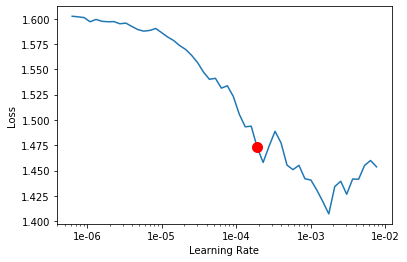

In [20]:
learner.recorder.plot(skip_end=10, suggestion=True)

In [21]:
# learner.fit_one_cycle(1,max_lr=2e-03,moms=(0.8,0.7))
learner.fit_one_cycle(1,max_lr=slice(1e-05, 1e-03))
learner.save('first_cycle')

seed_all(seed_val)
learner.load('first_cycle')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.199539,1.233606,0.510574,0.489426,01:02


Learner(data=TextClasDataBunch;

Train: LabelList (112364 items)
x: TextList
<s> Ġunintentionally Ġ- RR B - </s>,<s> Ġwill Ġneed Ġall Ġthe Ġluck Ġthey Ġcan Ġmuster Ġjust Ġfiguring Ġout Ġwho Ġ' s Ġwho Ġin Ġthis Ġpret entious Ġmess </s>,<s> Ġsomewhere Ġbetween ĠS ling ĠBlade Ġand ĠSouth Ġof ĠHeaven Ġ, ĠWest Ġof ĠHell </s>,<s> Ġreminds Ġat Ġevery Ġturn Ġof ĠElizabeth ĠBerk ley Ġ' s Ġflo pping Ġdolphin - g asm </s>,<s> Ġthe ĠMag i </s>
y: CategoryList
2,0,2,1,2
Path: .;

Valid: LabelList (12484 items)
x: TextList
<s> Ġk idd ie Ġentertainment </s>,<s> Ġfinally Ġmakes ĠSex ĠWith ĠStr angers Ġ, Ġwhich Ġopens Ġtoday Ġin Ġthe ĠNew ĠYork Ġmetropolitan Ġarea Ġ, Ġso Ġdist ast eful </s>,<s> Ġmuch Ġas Ġthey Ġlove Ġthemselves </s>,<s> Ġupdate Ġher Ġbeloved Ġgenre </s>,<s> Ġbeautiful Ġwomen </s>
y: CategoryList
2,0,2,2,2
Path: .;

Test: None, model=CustomTransformerModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (wor

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.32E-03


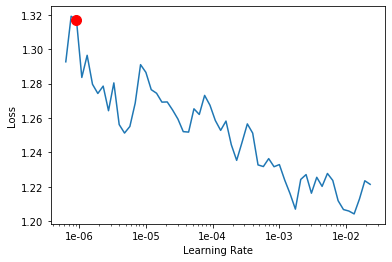

In [23]:
learner.lr_find()
learner.recorder.plot(skip_end=10, suggestion=True)

In [24]:
learner.freeze_to(-2)
# lr = 1e-5
learner.fit_one_cycle(1, max_lr=slice(1e-06, 1e-04))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.116296,1.071130,0.568728,0.431272,01:09


In [26]:
learner.callbacks.append(ShowGraph(learner))
print(learner.model)

CustomTransformerModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(i